# STEP 1: Data preprocessing

In [1]:
# importing the packages
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [2]:
df = pd.read_csv('OnlineRetail.csv', encoding='unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
# Remove the leading and the trailing characters from the column
df['Description'] = df['Description'].str.strip()

In [4]:
# Dropping rows while including the InvoiceNo column
df.dropna(axis=0, subset=['InvoiceNo'], inplace = True)

In [5]:
# Converting the InvoiceNo column to a string format
df.InvoiceNo = df.InvoiceNo.astype('str')

In [6]:
# Removing the invoice numbers containing the credit transactions
df = df[~df.InvoiceNo.str.contains('C')]

In [ ]:
# Checking the count of orders for each country
df.Country.value_counts()

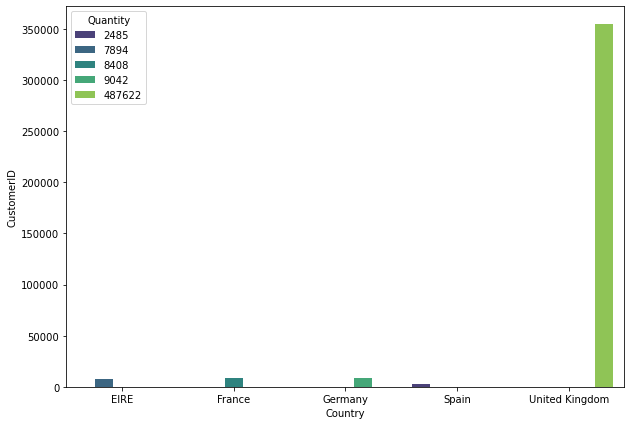

In [128]:
# Visualizing the customers of the top 5 countries which have the highest orders 

visualizer = df[df.Country.isin(['France','Germany','United Kingdom', 'EIRE', 'Spain'])]

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

visualizer = visualizer.groupby('Country')[['CustomerID','Quantity']].count()
visualizer.reset_index(inplace=True)

plt.figure(figsize = (10,7))

sns.barplot(x = 'Country' , y = 'CustomerID', data = visualizer, palette = 'viridis', hue = 'Quantity' )
plt.show()

In [22]:
# Creating a basket of one row per item
basket = df[df['Country'] == "Japan"].groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

In [25]:
# Let us now convert any positive number as '1' and anything negative as '0'
def encoder(data):
    if data <= 0:
        return 0
    if data > 0:
        return 1

basket_sets = basket.applymap(encoder)
#basket_sets.drop('POSTAGE', axis = 1, inplace = True)
basket_sets.head()

Description,12 PENCILS TALL TUBE RED RETROSPOT,20 DOLLY PEGS RETROSPOT,3 HOOK HANGER MAGIC GARDEN,36 PENCILS TUBE RED RETROSPOT,4 TRADITIONAL SPINNING TOPS,5 HOOK HANGER MAGIC TOADSTOOL,5 HOOK HANGER RED MAGIC TOADSTOOL,60 CAKE CASES DOLLY GIRL DESIGN,ABC TREASURE BOOK BOX,ASSORTED EASTER GIFT TAGS,...,VINTAGE DONKEY TAIL GAME,VINTAGE KEEPSAKE BOX PARIS DAYS,VINTAGE LEAF MAGNETIC NOTEPAD,WALL TIDY RETROSPOT,WHITE HEART CONFETTI IN TUBE,WHITE SOAP RACK WITH 2 BOTTLES,WHITE WIRE EGG HOLDER,WOODEN HAPPY BIRTHDAY GARLAND,WOODEN SCHOOL COLOURING SET,WORLD WAR 2 GLIDERS ASSTD DESIGNS
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
537218,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537899,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
538397,0,1,1,0,0,1,1,0,0,1,...,0,0,0,0,0,0,1,1,0,0
543179,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
543518,0,0,1,0,0,0,1,0,0,1,...,0,1,0,1,0,0,0,0,0,0


In [26]:
# Removing unnecessary/wrongly included items from the basket_Set
#ser = pd.Series(list(basket_sets))
#ser[~ser.astype('str').str.contains('wrongly|wrong|wet|thrown|throw|damage|test|website')][:4072]

In [27]:
#basket_sets = basket_sets.iloc[:,:4072]

# STEP 2: Generate frequent itemsets using Apriori algorithm

We will be using a minimum support value of 10% and a minimum threshold of 1

In [38]:
frequent_itemsets = apriori(basket_sets , min_support = 0.2
                            , use_colnames=True)
assoc_rules = association_rules(frequent_itemsets, metric = 'lift', min_threshold = 0.6)
assoc_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(BASKET OF TOADSTOOLS),(RED SPOTTY BISCUIT TIN),0.210526,0.263158,0.210526,1.0,3.80,0.155125,inf
1,(RED SPOTTY BISCUIT TIN),(BASKET OF TOADSTOOLS),0.263158,0.210526,0.210526,0.8,3.80,0.155125,3.947368
2,(BASKET OF TOADSTOOLS),"(SET 3 RETROSPOT TEA,COFFEE,SUGAR)",0.210526,0.210526,0.210526,1.0,4.75,0.166205,inf
3,"(SET 3 RETROSPOT TEA,COFFEE,SUGAR)",(BASKET OF TOADSTOOLS),0.210526,0.210526,0.210526,1.0,4.75,0.166205,inf
4,(CHARLOTTE BAG DOLLY GIRL DESIGN),(LUNCH BAG DOLLY GIRL DESIGN),0.210526,0.210526,0.210526,1.0,4.75,0.166205,inf


# STEP 3: Classifying based on the lift values

In [39]:
assoc_rules = assoc_rules.iloc[:,[0,1,4,5,6]]
assoc_rules[(assoc_rules['lift'] > 3.8) &
           (assoc_rules['confidence'] > 0.6)]

,antecedents,consequents,support,confidence,lift
0,(BASKET OF TOADSTOOLS),(RED SPOTTY BISCUIT TIN),0.210526,1.0,3.80
1,(RED SPOTTY BISCUIT TIN),(BASKET OF TOADSTOOLS),0.210526,0.8,3.80
2,(BASKET OF TOADSTOOLS),"(SET 3 RETROSPOT TEA,COFFEE,SUGAR)",0.210526,1.0,4.75
3,"(SET 3 RETROSPOT TEA,COFFEE,SUGAR)",(BASKET OF TOADSTOOLS),0.210526,1.0,4.75
4,(CHARLOTTE BAG DOLLY GIRL DESIGN),(LUNCH BAG DOLLY GIRL DESIGN),0.210526,1.0,4.75
5,(LUNCH BAG DOLLY GIRL DESIGN),(CHARLOTTE BAG DOLLY GIRL DESIGN),0.210526,1.0,4.75
6,(CHARLOTTE BAG DOLLY GIRL DESIGN),(RED SPOTTY BISCUIT TIN),0.210526,1.0,3.80
7,(RED SPOTTY BISCUIT TIN),(CHARLOTTE BAG DOLLY GIRL DESIGN),0.210526,0.8,3.80
8,(LUNCH BAG DOLLY GIRL DESIGN),(RED SPOTTY BISCUIT TIN),0.210526,1.0,3.80
9,(RED SPOTTY BISCUIT TIN),(LUNCH BAG DOLLY GIRL DESIGN),0.210526,0.8,3.80
